In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy.fft import fft, fftfreq, fftshift

In [40]:
# read from file
calib = np.genfromtxt('part3-equil.csv', delimiter=',')
trial = np.genfromtxt('part3-oscil.csv', delimiter=',')

In [41]:
def bounds(domain):
    return np.array([ np.floor(np.min(t_peak)), np.ceil(np.max(t_peak)) ])

def line(model):
    m = f"{model.slope:.3f}"
    dm = f"{model.stderr:.3f}"
    b = f"{model.intercept:.3f}"
    db = f"{model.intercept_stderr:.3f}"
    return f"$y = ({m} \pm {dm})\cdot x + ({b} \pm {db})$"

In [42]:
# isolate into arrays
[_, a_calib] = calib[1:].T
[t_noisy, a_shifted] = trial[1:].T

In [43]:
a_eq = np.average(a_calib) # equilibrium accel
a_noisy = a_shifted - a_eq # zero out equilibrium

a_eq, np.average(a_shifted), np.average(a_noisy)

(-8.174282933217823, -8.138104565277665, 0.036178367940156844)

In [44]:
# linest2 = scipy.stats.linregress(x2, F2)
# model2 = lambda x: x*linest2.slope + linest2.intercept

# linest4 = scipy.stats.linregress(x4, F4)
# model4 = lambda x: x*linest4.slope + linest4.intercept

# linest2, linest4

## Setup

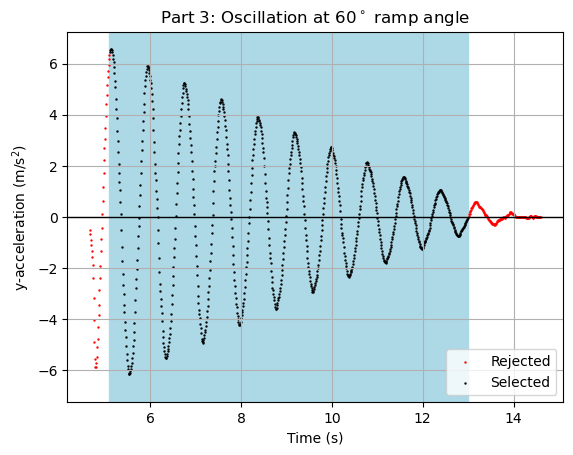

In [45]:
plt.title("Part 3: Oscillation at $60^\circ$ ramp angle")
plt.xlabel("Time (s)")
plt.ylabel("y-acceleration (m/s$^2$)")
amax = np.max(np.abs(a_noisy))
plt.ylim(-amax*1.1, amax*1.1)

noise_filter = np.where(np.logical_and(5.1 < t_noisy, t_noisy < 13))
noise_select = np.where(np.logical_or(5.1 > t_noisy, t_noisy > 13))
t = t_noisy[noise_filter]
a = a_noisy[noise_filter]
plt.axvspan(
    5.1, 
    13, 
    color="lightblue")

plt.axhline(0, color="black", lw=1)
plt.scatter(t_noisy[noise_select], a_noisy[noise_select], s=0.5, color="red", label="Rejected")
plt.scatter(t, a, s=0.5, color="black", label="Selected")
plt.legend(loc="lower right")
plt.grid()

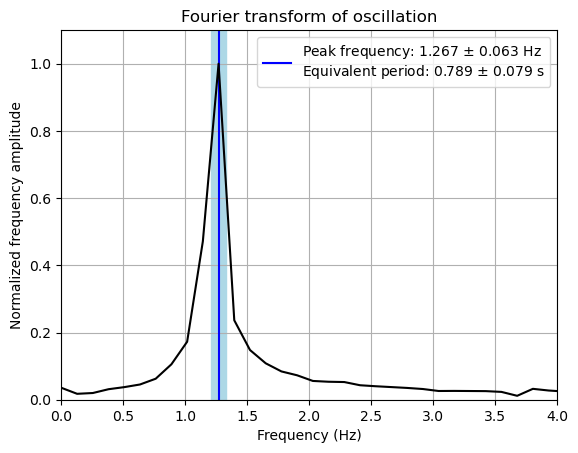

In [46]:
sp = np.abs(fftshift(fft(a)))
sp /= np.max(sp)
# sp = np.abs(fftshift(fft(np.sin(t))))
sampling_rate = 1 / np.average(np.diff(t))
freq = fftshift(fftfreq(t.size, 1/sampling_rate))
bin_width = np.average(np.diff(freq))

maxfreq = np.average(np.abs(freq[np.where(sp == np.max(sp))]))
leftfreq = maxfreq - bin_width/2
rightfreq = maxfreq + bin_width/2
plt.axvline(maxfreq, color="blue", 
            label=f"""Peak frequency: {maxfreq:.3f} $\pm$ {bin_width/2:.3f} Hz
Equivalent period: {1/maxfreq:.3f} $\pm$ {1/leftfreq - 1/rightfreq:.3f} s""")
plt.axvspan(
    leftfreq, 
    rightfreq, 
    color="lightblue")

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(0, 4)
plt.ylim(0, 1.1)
plt.plot(freq, sp, color="black")
plt.grid()
plt.legend()
plt.show()

In [47]:
tau = 2*np.pi

## Fit 1

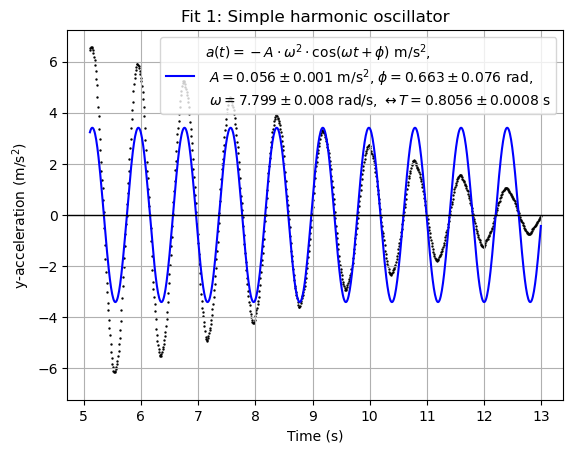

In [69]:
model_sho = (
    lambda t, A, omega, phi: 
    -A * (omega**2) * np.cos(omega*t + phi)
)
[A_sho, omega_sho, phi_sho], cov_sho = scipy.optimize.curve_fit(
    model_sho, 
    t, a, 
    [1, maxfreq*2*np.pi, 0]
)

[dA_sho, dOmega_sho, dPhi_sho] = np.sqrt(np.diagonal(cov_sho))

t_sho = tau/omega_sho # Period
dT_sho = t_sho * dOmega_sho / omega_sho # Period error

a_sho = lambda t: model_sho(t, A_sho, omega_sho, phi_sho)
plt.plot(t, a_sho(t), color="blue", 
         label=f"""$a(t) = -A \cdot \omega^2 \cdot \cos(\omega t + \phi)$ m/s$^2$,
 $A = {A_sho:.3f} \pm {dA_sho:.3f}$ m/s$^2$, $\phi = {phi_sho:.3f} \pm {dPhi_sho:.3f}$ rad,
 $\omega = {omega_sho:.3f} \pm {dOmega_sho:.3f}$ rad/s, $\leftrightarrow T = {t_sho:.4f} \pm {dT_sho:.4f}$ s"""
)
plt.title("Fit 1: Simple harmonic oscillator")
plt.xlabel("Time (s)")
plt.ylabel("y-acceleration (m/s$^2$)")
plt.ylim(-amax*1.1, amax*1.1)

plt.scatter(t, a, s=0.5, color="black")
plt.axhline(0, color="black", lw=1)

plt.grid()
plt.legend()

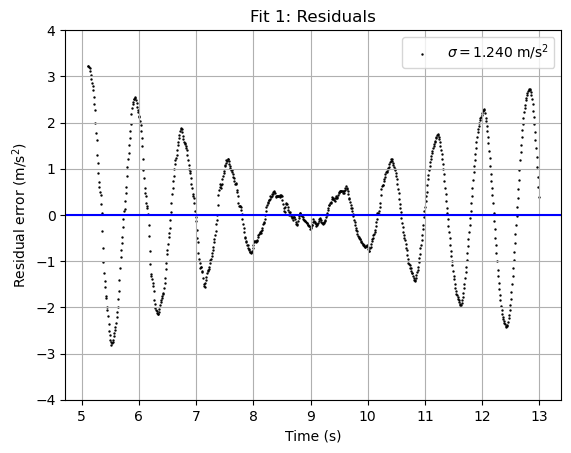

In [49]:
a_sho_res = a - a_sho(t)
dA_sho = scipy.stats.tstd(a_sho_res)

plt.title("Fit 1: Residuals")
plt.xlabel("Time (s)")
plt.ylabel("Residual error (m/s$^2$)")
plt.ylim(-4, 4)
plt.grid()
plt.scatter(t, a_sho_res, s=0.5, color="black", label=f"$\sigma = {dA_sho:.3f}$ m/s$^2$")
plt.axhline(0, color="blue")
plt.legend()

## Fit 2

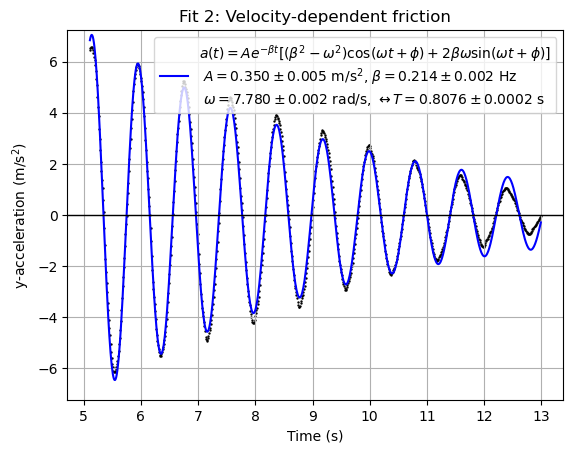

In [68]:
model_vis = (
    lambda t, A, beta, omega, phi: 
    A * np.exp(-beta*t) * (
        ((beta**2) - (omega**2))*np.cos(omega*t + phi)
        + 2*beta*omega*np.sin(omega*t + phi)
    )
)
[A_vis, beta_vis, omega_vis, phi_vis], cov_vis = scipy.optimize.curve_fit(
    model_vis, 
    t, a, 
    [1, 1, maxfreq*2*np.pi, 0]
)

[dA_vis, dBeta_vis, dOmega_vis, dPhi_vis] = np.sqrt(np.diagonal(cov_vis))

t_vis = tau/omega_vis # Period
dT_vis = t_vis * dOmega_vis / omega_vis # Period error

a_vis = lambda t: model_vis(t, A_vis, beta_vis, omega_vis, phi_vis)
plt.plot(t, a_vis(t), color="blue", 
         label=f"""$a(t) = A e^{{-\\beta t}}[(\\beta^2 - \omega^2)\cos(\omega t+\phi) + 2\\beta\omega\sin(\omega t + \phi)]$
 $A = {A_vis:.3f} \pm {dA_vis:.3f}$ m/s$^2$, $\\beta = {beta_vis:.3f} \pm {dBeta_vis:.3f}$ Hz
 $\omega = {omega_vis:.3f} \pm {dOmega_vis:.3f}$ rad/s, $\leftrightarrow T = {t_vis:.4f} \pm {dT_vis:.4f}$ s"""
)
plt.title("Fit 2: Velocity-dependent friction")
plt.xlabel("Time (s)")
plt.ylabel("y-acceleration (m/s$^2$)")
plt.ylim(-amax*1.1, amax*1.1)

plt.scatter(t, a, s=0.5, color="black")
plt.axhline(0, color="black", lw=1)

plt.grid()
plt.legend()

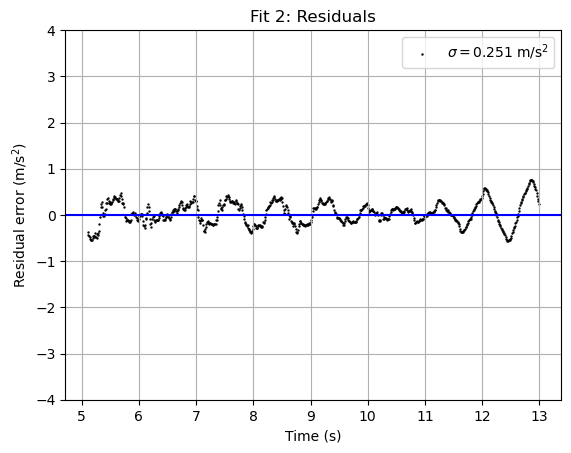

In [85]:
a_vis_res = a - a_vis(t)
dA_vis = scipy.stats.tstd(a_vis_res)

plt.title("Fit 2: Residuals")
plt.xlabel("Time (s)")
plt.ylabel("Residual error (m/s$^2$)")
plt.ylim(-4, 4)
plt.grid()
plt.scatter(t, a_vis_res, s=0.5, color="black", label=f"$\sigma = {dA_vis:.3f}$ m/s$^2$")
plt.axhline(0, color="blue")
plt.legend()

## Fit 3

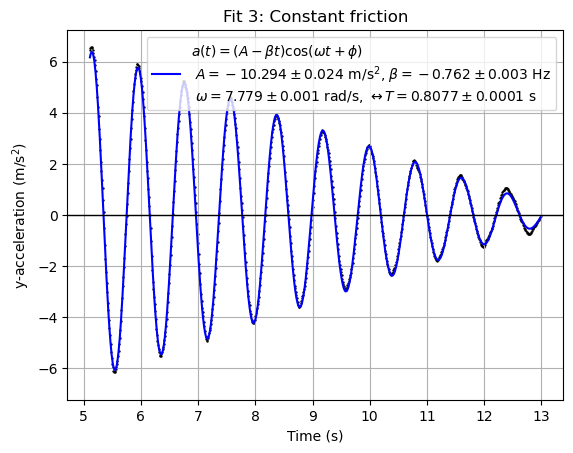

In [104]:
model_con = (
    lambda t, A, beta, omega, phi: 
    (A - beta*t) * np.cos(omega*t + phi)
)
[A_con, beta_con, omega_con, phi_con], cov_con = scipy.optimize.curve_fit(
    model_con, 
    t, a, 
    [1, 1, maxfreq*2*np.pi, 0]
)

[dA_con, dBeta_con, dOmega_con, dPhi_con] = np.sqrt(np.diagonal(cov_con))

t_con = tau/omega_con # Period
dT_con = t_con * dOmega_con / omega_con # Period error

a_con = lambda t: model_con(t, A_con, beta_con, omega_con, phi_con)
plt.plot(t, a_con(t), color="blue", 
         label=f"""$a(t) = (A - \\beta t)\cos(\omega t + \phi)$
 $A = {A_con:.3f} \pm {dA_con:.3f}$ m/s$^2$, $\\beta = {beta_con:.3f} \pm {dBeta_con:.3f}$ Hz
 $\omega = {omega_con:.3f} \pm {dOmega_con:.3f}$ rad/s, $\leftrightarrow T = {t_con:.4f} \pm {dT_con:.4f}$ s"""
)
plt.title("Fit 3: Constant friction")
plt.xlabel("Time (s)")
plt.ylabel("y-acceleration (m/s$^2$)")
plt.ylim(-amax*1.1, amax*1.1)

plt.scatter(t, a, s=0.5, color="black")

plt.axhline(0, color="black", lw=1)

plt.grid()
plt.legend()

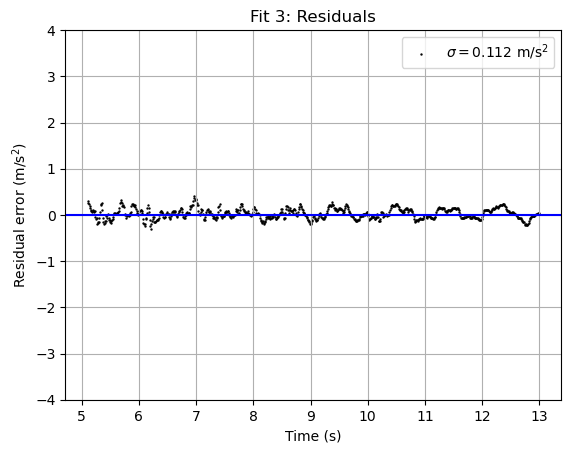

In [84]:
a_con_res = a - a_con(t)
dA_con = scipy.stats.tstd(a_con_res)

plt.title("Fit 3: Residuals")
plt.xlabel("Time (s)")
plt.ylabel("Residual error (m/s$^2$)")
plt.ylim(-4, 4)
plt.grid()
plt.scatter(t, a_con_res, s=0.5, color="black", label=f"$\sigma = {dA_con:.3f}$ m/s$^2$")
plt.axhline(0, color="blue")
plt.legend()

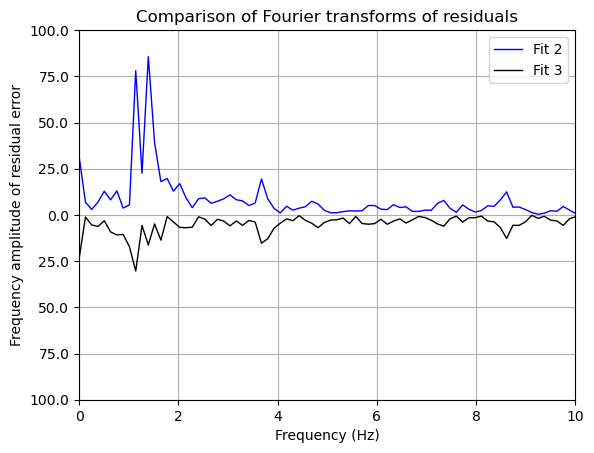

In [103]:
sp_vis = np.abs(fftshift(fft(a_vis_res)))
sp_con = np.abs(fftshift(fft(a_con_res)))

plt.title("Comparison of Fourier transforms of residuals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency amplitude of residual error")
plt.xlim(0, 10)
plt.ylim(-100,100)
plt.yticks(np.linspace(-100,100,9), np.abs(np.linspace(-100,100,9)))
# plt.ylim(0, 1.1)
plt.plot(freq, sp_vis, color="blue", lw=1, label="Fit 2")
plt.plot(freq, -sp_con, color="black", lw=1, label="Fit 3")
plt.grid()
plt.legend()
plt.show()

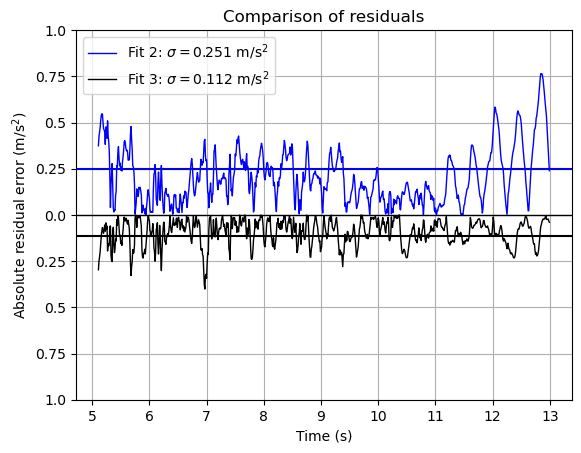

In [74]:
plt.title("Comparison of residuals")
plt.xlabel("Time (s)")
plt.ylabel("Absolute residual error (m/s$^2$)")
plt.ylim(-1, 1)

# plt.plot(t, np.abs(a_sho_res), lw=1, color="teal", label="Fit 2")
plt.plot(t, np.abs(a_vis_res), lw=1, color="blue", label=f"Fit 2: $\sigma = {dA_vis:.3f}$ m/s$^2$")
plt.plot(t, -np.abs(a_con_res), lw=1, color="black", label=f"Fit 3: $\sigma = {dA_con:.3f}$ m/s$^2$")
plt.axhline(0, color="black", lw=1)
plt.axhline(dA_vis, color="blue")
plt.axhline(-dA_con, color="black")
plt.yticks(np.linspace(-1,1,9), np.abs(np.linspace(-1,1,9)))
plt.grid()
plt.legend()

## Blah

In [17]:
a_abs = np.abs(a)

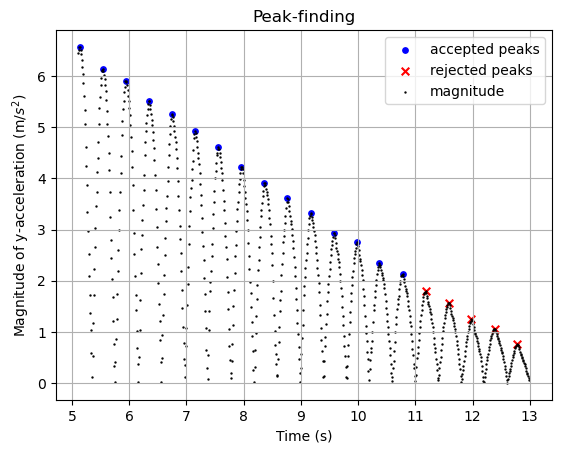

In [18]:
a_window = [np.max(a_abs[i:]) for i in np.arange(a_abs.size)]

period = 0.1 # ???

maxcond = np.where(a_abs >= a_window) # select only values that are more than anything after them
peakcond = np.where(np.abs(np.diff(t[maxcond])) > period)[0] + 1 # select only times that are separated
peakcond = np.array([ 0, *peakcond ]) # include first peak
peakcutoff = -5 # reject low peaks

a_peak = a_abs[maxcond][peakcond[:peakcutoff]]
t_peak = t[maxcond][peakcond[:peakcutoff]]

a_rejected = a_abs[maxcond][peakcond[peakcutoff:]]
t_rejected = t[maxcond][peakcond[peakcutoff:]]

t_model = bounds(t_peak)

# plt.scatter(t, a_window, s=0.5)

plt.title("Peak-finding")
plt.ylabel("Magnitude of y-acceleration (m/$s^2$)")
plt.xlabel("Time (s)")
plt.grid()
plt.scatter(t_peak, a_peak, s=15, color="blue", label="accepted peaks")
plt.scatter(t_rejected, a_rejected, s=30, color="red", label="rejected peaks", marker="x")
plt.scatter(t, a_abs, s=0.5, color="black", label="magnitude")
plt.legend()

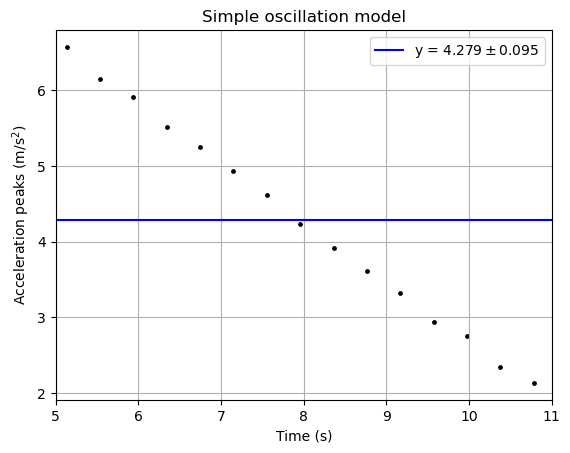

In [19]:
a_peak_l2 = np.average(a_peak)
a_peak_stderr = scipy.stats.tstd(a_peak)/a_peak.size

plt.title("Simple oscillation model")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration peaks (m/s$^2$)")
plt.xlim(*t_model)
plt.grid()
plt.scatter(t_peak, a_peak, s=6, color="black")
plt.axhline(a_peak_l2, label=f"y = ${a_peak_l2:.3f} \pm {a_peak_stderr:.3f}$", color="blue")
plt.legend()

In [20]:
model_const = scipy.stats.linregress(t_peak, a_peak)

model_const

LinregressResult(slope=-0.7894176556479938, intercept=10.561455961796222, rvalue=-0.9994006013463355, pvalue=2.2276742603647976e-20, stderr=0.0075840876496593365, intercept_stderr=0.06178832690566528)

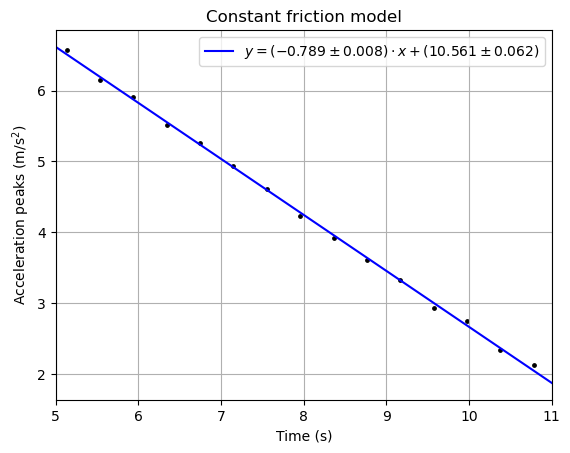

In [21]:
a_peak_model = lambda t: t*model_const.slope + model_const.intercept

plt.title("Constant friction model")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration peaks (m/s$^2$)")
plt.xlim(*t_model)
plt.grid()
plt.scatter(t_peak, a_peak, s=6, color="black")
plt.plot(t_model, a_peak_model(t_model), label=line(model_const), color="blue")
plt.legend()

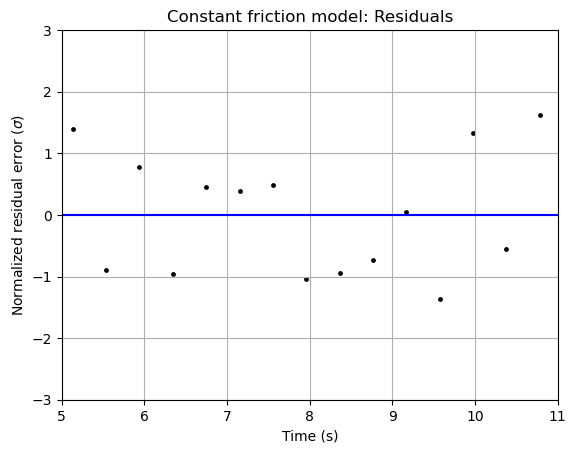

In [22]:
a_peak_res = a_peak - a_peak_model(t_peak)

plt.title("Constant friction model: Residuals")
plt.xlabel("Time (s)")
plt.ylabel("Normalized residual error ($σ$)")
plt.xlim(*t_model)
plt.ylim(-3, 3)
plt.grid()
plt.scatter(t_peak, a_peak_res/scipy.stats.tstd(a_peak_res), s=6, color="black")
plt.axhline(0, color="blue")

In [23]:
a_log = np.log(a_peak / a_peak[0])

model_vis = scipy.stats.linregress(t_peak, a_log)
model_vis

LinregressResult(slope=-0.19634894965334007, intercept=1.0767874113623739, rvalue=-0.9905358422197077, pvalue=1.3428824361687227e-12, stderr=0.007545928716669464, intercept_stderr=0.06147744223042613)

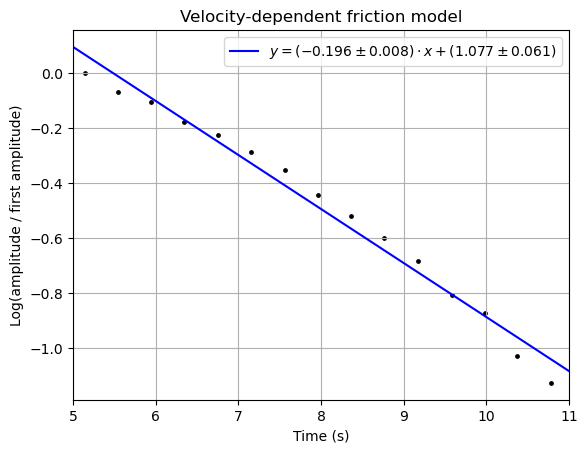

In [24]:
plt.title("Velocity-dependent friction model")
plt.xlabel("Time (s)")
plt.ylabel("Log(amplitude / first amplitude)")
plt.xlim(*t_model)
plt.grid()

a_log_model = lambda t: t*model_vis.slope + model_vis.intercept

plt.scatter(t_peak, a_log, s=6, color="black")
plt.plot(t_model, a_log_model(t_model), label=line(model_vis), color="blue")
plt.legend()

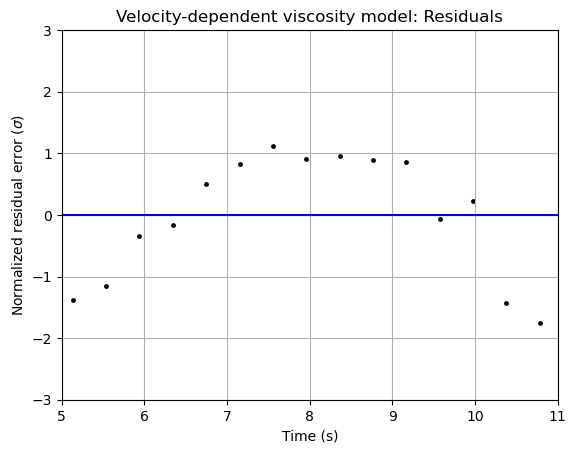

In [25]:
a_log_res = a_log - a_log_model(t_peak)

plt.title("Velocity-dependent viscosity model: Residuals")
plt.xlabel("Time (s)")
plt.ylabel("Normalized residual error ($σ$)")
plt.xlim(*t_model)
plt.ylim(-3, 3)
plt.grid()
plt.scatter(t_peak, a_log_res/scipy.stats.tstd(a_log_res), s=6, color="black")
plt.axhline(0, color="blue")

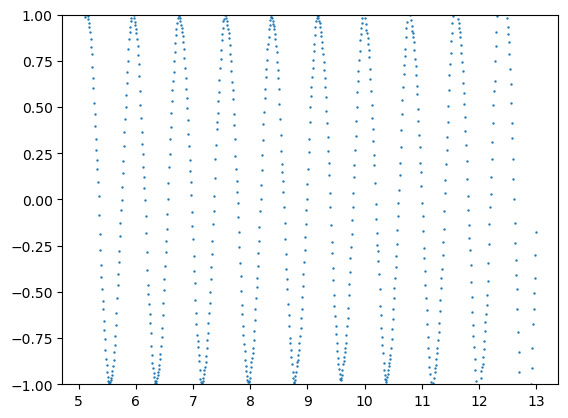

In [26]:
plt.ylim(-1,1)
plt.scatter(t, a/a_peak_model(t), s=0.5)